# **Similarity of European Central Bank communications and its impact on financial markets: and extension**

### Students:
- #### Ilona Ciobanu
- #### Camilo Saldarriaga
- #### Andrew Walters


* [1. Scrapping the conferences](#chapter1)
    * [1.1 Scrapping the links](#section_1_1)
    * [1.2 Scrapping the conference texts ](#section_1_2)

* [2. Import additional data](#chapter2)
    * [2.1 Importing the MRO rates ](#section_2_1)
    * [2.2 Importing DJEUROSTOXX50 ](#section_2_2)
    * [2.3 Importing Quarterly real GDP ](#section_2_3)
    * [2.4 Importing the Harmonised Index Consumer Prices (HICP)](#section_2_4)

* [3. Cleaning ECB communications and matching meetings with rate changes](#chapter3)
    * [3.1 Cleaning the text](#section_3_1)
    * [3.2 Matching ECB meetings dates with MRO dates](#section_3_2)
    * [3.3 Replication of Table 1 ](#section_3_3)



* [4. Communications analysis ](#chapter4)
    * [4.1 Measure of similarity between communications](#section_4_1)
    * [4.2 Measure of pessimism/Sentiment analysis](#section_4_2)


* [5.Data merging ](#chapter5)
    * [5.1 Merging](#section_5_1)
    * [5.2 Craeting Time and Time count variables ](#section_5_2)
    * [5.3 Appliying the log transformation to similarity ](#section_5_3)
    

* [6.Replication of Table2: Descriptive statistics ](#chapter6)

* [7. Estimations ](#chapter7)
    * [7.1 Table 3  ](#section_7_1)
    * [7.2 Table 4 ](#section_7_2)
    

In [1]:
import requests


from bs4 import BeautifulSoup
import pandas as pd



import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import re

from typing import Optional, Callable
from collections import defaultdict


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.lm.preprocessing import everygrams
from string import punctuation
from unidecode import unidecode_expect_ascii

from datetime import timedelta
from datetime import datetime

import statsmodels.api as sm

from statsmodels.tsa.filters.hp_filter import hpfilter

Define plots default size and style:

In [2]:
sns.set(rc={'figure.figsize':(9,3)})
sns.set_style("white")

Define helper functions

In [3]:
def make_sentiment_dict(pos_words:list[str], neg_words:list[str]) -> dict[str, float]:
    sent_dict = defaultdict(lambda: 0)
    sent_dict.update({w.lower(): 1 for w in POS_WORDS})
    sent_dict.update({w.lower():-1 for w in NEG_WORDS})

    return sent_dict


def preprocess_text(s: str, stemmer: Optional[Callable]=None) -> list[str]:
    '''
    Prepare a text string for sentiment analysis

    Parameters
    ----------
    s: str,
        The string to be preprocessed

    stemmer: callable, Optional
        A stemming function to be applied to each token in the string. Should
        take a string and return a string.

    Returns
    ----------
    tokens: list of str,
        A list of tokens, lowercased and stemmed.
    '''

    if not stemmer:
        stemmer = lambda x: x

    s = s.lower()
    tokens = word_tokenize(s)
    stemmed_tokens = [stemmer(w) for w in tokens]

    return stemmed_tokens

def classify_sentences(corpus: list[str],
                       pos_words: list[str],
                       neg_words: list[str],
                       stemmer: Optional[Callable]=None,
                       average_method:str='all') -> list[float]:
    """
    Classify the sentiment of each text in a corpus based on a fixed dictionary.

    Parameters
    -----------
    corpus: list of strings
        A "corpus" of texts. Each text will be converted to a single number,
        representing the sentiment of the text.

    pos_words: list of str
        A list of words to be considered as positive in the sentiment
        analysis

    neg_words: list of str
        A list of words to be considered as negative in the sentiment
        analysis.

    stemmer: callable, optional
        A stemming function to be applied to each token in the string. Should
        take a string and return a string.

    average_method: str, default = 'all'
        The method used to normalize the sentiment scores between 0 and 1.
            "all" will divide the sentiment by the total number of tokens in the text
            "has_sentiment" will divide by the number of non-zero sentiment tokens

    Returns
    ----------
    scores: list of floats
        A list of sentiment scores

    """
    if average_method not in ['all', 'has_sentiment']:
        raise NotImplementedError()

    sent_dict = make_sentiment_dict(pos_words, neg_words)

    scores = []
    for text in corpus:
        tokens = preprocess_text(text, stemmer)
        word_scores = list([sent_dict[token] for token in tokens])
        n = len(tokens) if average_method == 'all' else sum([abs(x) for x in word_scores])
        score = sum(word_scores) / n
        scores.append(score)
    return scores

# 1. Scrapping the conferences <a id="chapter1"></a>

## 1.1 Scrapping the links <a id="section_1_1"></a>

In [352]:
url = "https://www.ecb.europa.eu/press/pressconf/{}/html/index_include.en.html"

urls = []

df =[]

for year in range(1990, 2025):
    soup = BeautifulSoup(requests.get(url.format(year)).content, "html.parser")
    for a in soup.select(".title a")[::-1]:
      date = a.find_previous(class_="date").text
      name = a.text
      link = "https://www.ecb.europa.eu" + a["href"]
      urls.append({'date': date, 'Name': name, 'Link': link})

df = pd.DataFrame(urls)

#Keep only monetary policy statements
df = df[df['Name'].str.contains('Monetary policy statement|Introductory statement')==True]
df = df[df['Name'].str.contains('Introductory statement on the winning design chosen in the international urban planning and architectural design competition')==False]

In [353]:
df

date                                               Name  \
0          9 June 1998  Willem F. Duisenberg: ECB Press conference: In...   
1          8 July 1998  Willem F. Duisenberg: ECB Press conference: In...   
2    11 September 1998  Willem F. Duisenberg: ECB Press conference: In...   
3      13 October 1998  Willem F. Duisenberg: Introductory statement w...   
4      3 November 1998  Willem F. Duisenberg: Introductory statement w...   
..                 ...                                                ...   
272       27 July 2023  Christine Lagarde, Luis de Guindos: Monetary p...   
273  14 September 2023  Christine Lagarde, Luis de Guindos: Monetary p...   
274    26 October 2023  Christine Lagarde, Luis de Guindos: Monetary p...   
275   14 December 2023  Christine Lagarde, Luis de Guindos: Monetary p...   
276    25 January 2024  Christine Lagarde, Luis de Guindos: Monetary p...   

                                                  Link  
0    https://www.ecb.europa.eu/press/pressconf/1998...  
1    https://www.ecb.europa.eu/press/pressconf/1998...  
2    https://www.ecb.europa.eu/press/pressconf/1998...  
3    https://www.ecb.europa.eu/press/pressconf/1998...  
4    https://www.ecb.europa.eu/press/pressconf/1998...  
..                                                 ...  
272  https://www.ecb.europa.eu/press/pressconf/2023...  
273  https://www.ecb.europa.eu/press/pressconf/2023...  
274  https://www.ecb.europa.eu/press/pressconf/2023...  
275  https://www.ecb.europa.eu/press/pressconf/2023...  
276  https://www.ecb.europa.eu/press/pressconf/2024...  

[268 rows x 3 columns]

## 1.2 Scrapping the conference texts <a id="section_1_2"></a>

In [354]:
alocation = []
apresident = []
avice_president = []
atext = []

for pressconf in df['Link']:
  url = pressconf
  data = requests.get(url)

  page = requests.get(url).content
  soup = BeautifulSoup(page, parser='lxml-parser', features='html')
  textbox = soup.find('main')

  name = soup.find('div', class_='title').get_text().strip()

  try:
      location_text = textbox.find(class_='ecb-publicationDate').get_text()
  except:
      location_text = "null"
      pass

  title_text = textbox.find('h2', class_='ecb-pressContentSubtitle').get_text()

  header = soup.find('head')
  header_text = header.find('title').get_text()


  title_text = title_text.replace('-', ' ')
  title_text = title_text.replace('European Central Bank', 'ECB')
  title_text = title_text.replace(' and ', ', and ')

  ps = textbox.find_all('p')

  items = title_text.split(',')

  president = None
  vice_president = None
  location = None
  date = None

  # Check for president
  Pres = [x for x in items if 'President' in x and 'ECB' in x and 'Vice' not in x]
  if len(Pres) == 1:
      p_idx = items.index(Pres[0]) - 1
      president = items[p_idx].strip()

  # Check for Vice-President
  VP = [x for x in items if 'Vice President' in x and 'ECB' in x]
  if len(VP) == 1:
      vp_idx = items.index(VP[0]) - 1
      vice_president = items[vp_idx]

  if location_text != 'null':
    #location
    location = location_text.split(', ')[0]
    location = location.strip()
    #date
    date = location_text.split(', ')[1]
    date = date.strip()
    #remove from start of text

  if location_text == 'null':
      if len(items) == 6:
          location = items[4]
          date = items[5]
      # Case 2: There was no comma separating the VP and the location.
      elif len(VP) > 0:
          candidate = VP[0].replace('Vice President of the ECB', '').strip()
          if candidate != '':
              location = candidate
              date = items[3]

  text='\n'.join([x.get_text() for x in ps])
  text = text.replace("\n", " ")
  text = text.replace("\t", " ")
  text = text.split('***', 1)[0]
  text = text.split('* * *', 1)[0]
  text = text.split('Transcript of the questions asked', 1)[0]
  text = text.split('Question:', 1)[0]
  text = text.split('QUESTION:', 1)[0]
  text = text.split('My first question would be', 1)[0]
  text = text.split('Question (translation):', 1)[0]
  text = text.split('Q:', 1)[0]
  text = text.replace("Click here for the transcript of questions and answers. ", "")
  text = text.replace("With the transcript of the questions and answers ", "")
  text = text.replace("With a transcript of the questions and answers ", "")
  text = text.replace("Reproduction is permitted provided that the source is acknowledged.", "")
  text = text.replace("Disclaimer Please note that related topic tags are currently available for selected content only.", "")

  if location_text != 'null':
    if text.startswith(location) == True:
      text = text.split(date[-4:], 1)[1]

  alocation.append(location)
  apresident.append(president)
  avice_president.append(vice_president)
  atext.append(text)



df['location'] = alocation
df['president'] = apresident
df['vice_president'] = avice_president
df['text'] = atext

In [4]:
df.to_csv("scraped_text.csv")

NameError: name 'df' is not defined

After a manual review, we discovered that there are 4 meeting dates that were omitted by the ECB webpage as they did not have press conference. We omit them as the original paper only considers conferences. For more information regarding those meetings, check:
*  16 March 2000 https://www.ecb.europa.eu/press/pr/date/2000/html/pr000316.en.html
*  31 August 2000 https://www.ecb.europa.eu/press/pr/date/2000/html/pr000831.en.html
*  17 September 2001 https://www.ecb.europa.eu/press/pr/date/2001/html/pr010917.en.html
*  08 October 2008 https://www.ecb.europa.eu/press/pr/date/2008/html/pr081008.en.html

In [5]:
df =  pd.read_csv("scrapped_text.csv").tail(-7)

Additionally, the manual review allowed us to identify that our file contained 2 ECB conferences that were not related with monetary policy meetings:
* 13 October 2003 https://www.ecb.europa.eu/press/pressconf/2003/html/is031013.en.html
* 20 January 2005 https://www.ecb.europa.eu/press/pressconf/2005/html/is050120.en.html

We proceed to remove those rows

In [6]:
df = df.drop(index=[62, 77])

# 2. Import additional data <a id="chapter2"></a>

## 2.1 Importing the MRO rates <a id="section_2_1"></a>

First we download and then import the MRO rates from the ECB website: https://data.ecb.europa.eu/main-figures/ecb-interest-rates-and-exchange-rates/key-ecb-interest-rates

In [7]:
colnames=['date', 'time_per', 'MRO']
rate_df = pd.read_csv("https://raw.githubusercontent.com/andrewpwalters/ecb/main/MRO_rates%20-%20MRO_rates%20(1).csv", names=colnames)

rate_df = rate_df.tail(-1)

rate_df

date   time_per  MRO
1      1/1/1999   1-Jan-99    3
2      1/2/1999   2-Jan-99    3
3      1/3/1999   3-Jan-99    3
4      1/4/1999   4-Jan-99    3
5      1/5/1999   5-Jan-99    3
...         ...        ...  ...
9173  2/11/2024  11-Feb-24  4.5
9174  2/12/2024  12-Feb-24  4.5
9175  2/13/2024  13-Feb-24  4.5
9176  2/14/2024  14-Feb-24  4.5
9177  2/15/2024  15-Feb-24  4.5

[9177 rows x 3 columns]

We convert the date format and set the date as index. We also extract the year, as it will be required to replicate Table 1

In [8]:
rate_df['date'] = pd.to_datetime(rate_df["date"])
rate_df.set_index("date", inplace = True)

mro = rate_df["MRO"].sort_index().copy().to_frame()

mro['year'] = mro.index.year

In [9]:
 mro = mro.head(-16)

mro

MRO  year
date                 
1999-01-01    3  1999
1999-01-02    3  1999
1999-01-03    3  1999
1999-01-04    3  1999
1999-01-05    3  1999
...         ...   ...
2024-01-26  4.5  2024
2024-01-27  4.5  2024
2024-01-28  4.5  2024
2024-01-29  4.5  2024
2024-01-30  4.5  2024

[9161 rows x 2 columns]

<Axes: xlabel='date'>

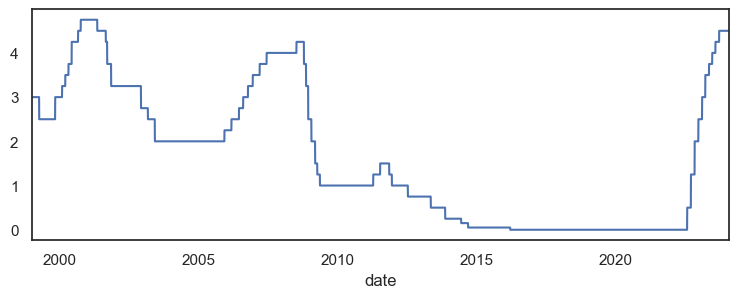

In [10]:
mro["MRO"].astype(float).plot()

## 2.2 Importing DJEUROSTOXX50 <a id="section_2_2"></a>

The data for the DJEurostoxx50 index was extracted from Google Finance, using the Google Sheets module. We used Google Finance instead of Yahoo Finance API, because it has the complete period of the analysis, while Yahoo Finance only has data from April 2007

Produced in google sheets with:

```
# =GOOGLEFINANCE("SX5E", "price", DATE(1998,1,1), DATE(2025,12,31), "DAILY")
```



In [11]:
stock_index = pd.read_csv("https://raw.githubusercontent.com/andrewpwalters/ecb/main/DJEurostoxx50%20-%20Sheet1.csv")

In [12]:
stock_index["Date"] =  pd.to_datetime(stock_index["Date"]).dt.date

stock_index.set_index("Date", inplace = True)

In [13]:
stock_index

Close
Date               
1998-04-06  3314.68
1998-04-07  3325.81
1998-04-08  3260.56
1998-04-09  3264.15
1998-04-14  3283.05
...             ...
2024-02-05  4655.27
2024-02-06  4690.87
2024-02-07  4678.85
2024-02-08  4710.78
2024-02-09  4715.87

[6584 rows x 1 columns]

<Axes: xlabel='Date', ylabel='Close'>

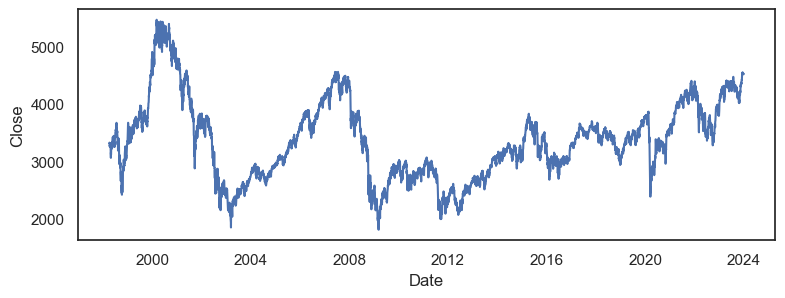

In [14]:
sns.lineplot(data=stock_index["Close"].head(6555))

The paper calculates Cumulative abnormal returns as:

$$CAR_i = \sum_{t=-5}^{5}AR_{i,t} $$
where:
$$AR_{i,t} = R_{i,t}- \overline{R}_{i,t} $$
and $\overline{R}_{i,t}$ is given by a 201 days moving average around 250 days to 50 days before the announcement:
$$\overline{R}_{i,t} = \frac{1}{201} \sum_{t=-250}^{50} $$

We calculate the returns and the moving average

In [15]:
stock_index["returns"] = np.log(stock_index["Close"]).diff()

stock_index["mean_returns"] = stock_index["returns"].rolling(201, min_periods = 100 ).mean().shift(50)

Now, we calculate the abnornal returns

In [16]:
stock_index["abnormal_returns"]= stock_index["returns"] - stock_index["mean_returns"]

In [17]:
pd.options.display.max_rows = 50

In [18]:
stock_index["cum_ab_returns"] = stock_index["abnormal_returns"].rolling(window=11, center = True).sum()

<Axes: xlabel='Date', ylabel='cum_ab_returns'>

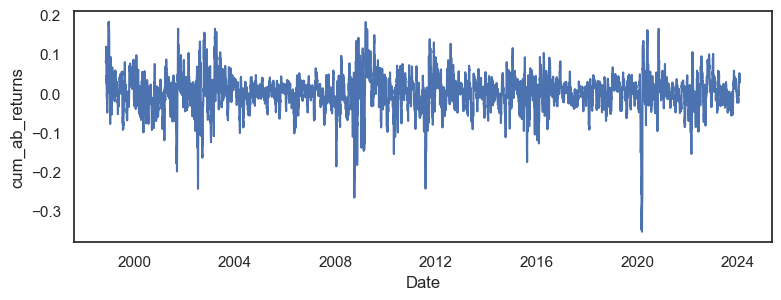

In [19]:
sns.lineplot(data=stock_index["cum_ab_returns"])

Finally, as the authors want to evaluate the size of the market reaction indepently of its direction, they use the absolute value of the Cumulative Abnormal returns. We proceed to calculate it.

In [20]:
stock_index["AV_cum_ab_returns"] = abs(stock_index["cum_ab_returns"])

<Axes: xlabel='Date', ylabel='AV_cum_ab_returns'>

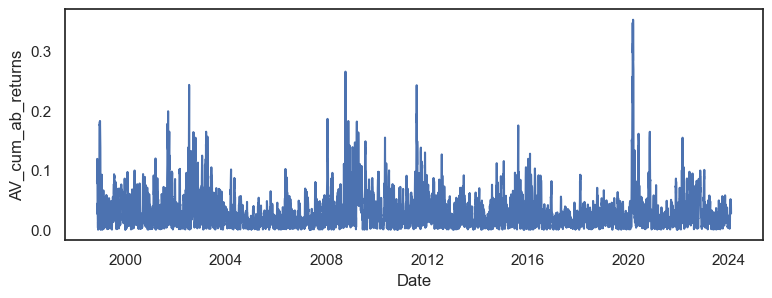

In [21]:
sns.lineplot(data=stock_index["AV_cum_ab_returns"])

## 2.3 Importing Quarterly real GDP <a id="section_2_3"></a>

We downloaded the quaterly real GDP for the Eurozone from FRED repository:

https://fred.stlouisfed.org/series/CLVMEURSCAB1GQEA19

Note that we are using EU19

In [22]:
GDP = pd.read_csv("https://raw.githubusercontent.com/andrewpwalters/ecb/main/CLVMEURSCAB1GQEA19.csv")

In [23]:
GDP.rename(columns = {"CLVMEURSCAB1GQEA19": "GDP_quart", "DATE": "date"}, inplace = True)

In [24]:
GDP

date  GDP_quart
0    1995-01-01  1836118.5
1    1995-04-01  1846681.1
2    1995-07-01  1853140.0
3    1995-10-01  1859628.1
4    1996-01-01  1861989.1
..          ...        ...
111  2022-10-01  2762310.1
112  2023-01-01  2764785.6
113  2023-04-01  2768259.4
114  2023-07-01  2764790.0
115  2023-10-01  2765634.4

[116 rows x 2 columns]

In [25]:
GDP["date"] = pd.to_datetime(GDP["date"])
GDP.set_index("date", inplace = True)

To obtain the output GAP, we use the hp filter

In [26]:
GDP["GDP_quart_ham_cyc"] = hpfilter(np.log(GDP["GDP_quart"]*4), lamb=1600)[0]
GDP["GDP_quart_ham_trend"] = hpfilter(np.log(GDP["GDP_quart"]*4), lamb=1600)[1]

<Axes: xlabel='date'>

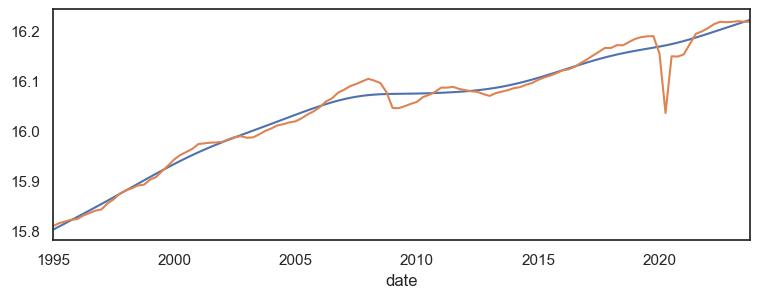

In [27]:
GDP["GDP_quart_ham_trend"].plot()
np.log(GDP["GDP_quart"]*4).plot()

In [28]:
GDP["output_gap_quart"] = GDP["GDP_quart_ham_cyc"]

[Text(0.5, 1.0, ' Quarterly GDP output GAP for the Euro zone')]

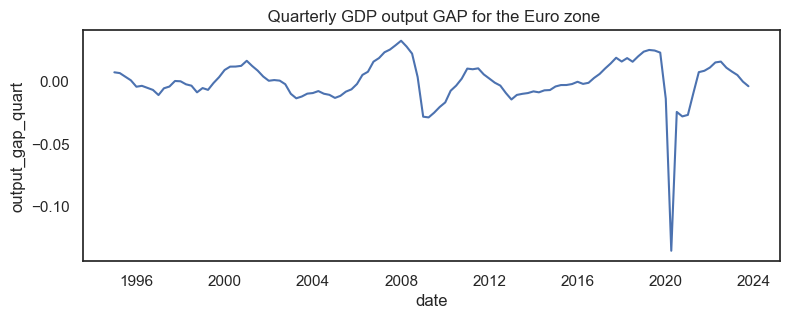

In [29]:
sns.lineplot(data=GDP["output_gap_quart"]).set(title=' Quarterly GDP output GAP for the Euro zone')

<Axes: xlabel='date', ylabel='output_gap_quart'>

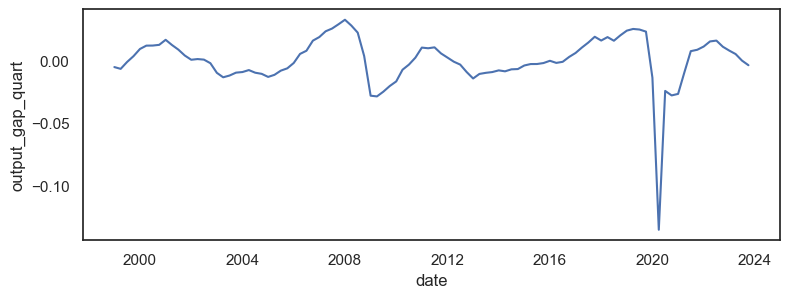

In [30]:
sns.lineplot(data=GDP["output_gap_quart"].tail(100))

## 2.4 Importing the Harmonised Index Consumer Prices (HICP) <a id="section_2_4"></a>

We download the Harmonised Index Consumer Prices (HICP) from FRED repository:  https://fred.stlouisfed.org/series/CP0000EZ19M086NEST

In [31]:
HICP = pd.read_csv("https://raw.githubusercontent.com/andrewpwalters/ecb/main/CP0000EZ19M086NEST.csv")
HICP.rename(columns = {"DATE":"date" , "CP0000EZ19M086NEST":"HICP"}, inplace= True)
HICP["date"] = pd.to_datetime(HICP["date"])

We use the log transformation to obtain inflation:

In [32]:
HICP["Inflation"] = HICP["HICP"].pct_change(12)

For merging purposes we extract the month-year values.

In [33]:
HICP["M-Y"] = HICP["date"].apply(lambda x: x.strftime('%B-%Y'))

<Axes: xlabel='date', ylabel='Inflation'>

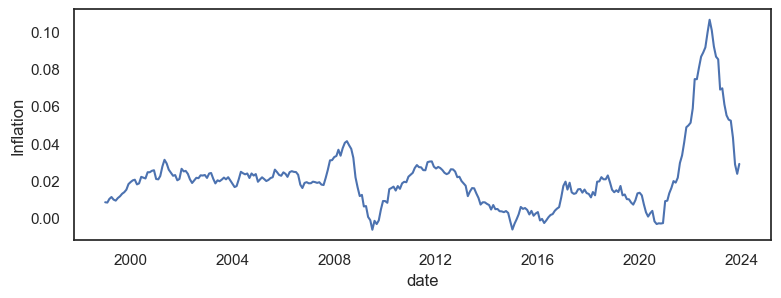

In [34]:
sns.lineplot(data=HICP.tail(300), x= HICP["date"].tail(300), y = HICP["Inflation"].tail(300) )

# 3. Cleaning ECB communications and matching meetings with rate changes<a id="chapter3"></a>

## 3.1 Cleaning the text <a id="section_3_1"></a>

We extract the words that do not provide value for the analysis

In [35]:
junk_strings = ['Click here for the transcript of questions and answers',
               'Jump to the transcript of the questions and answers',
                'With the transcript of the questions and answers',
                'With a transcript of the questions and answers']
junk_strings = [x.strip().lower() for x in junk_strings]

In [36]:
def clean_text(row):
    text = row.text
    date = row.date
    location = '' if pd.isna(row.location) else row.location
    lines = text.split('\n')

    result = []

    for line in lines:
        if date in line.strip() and location in line.strip():
            continue
        elif re.sub('[^\s\d\w]', '', line.strip().lower()) in junk_strings:
            continue
        result.append(line)
    return '\n'.join(result)

In [37]:
df

Unnamed: 0               date  \
7             7     7 January 1999   
8             8    4 February 1999   
9             9       4 March 1999   
10           10       8 April 1999   
11           11         6 May 1999   
..          ...                ...   
262         271       15 June 2023   
263         272       27 July 2023   
264         273  14 September 2023   
265         274    26 October 2023   
266         275   14 December 2023   

                                                  Name  \
7    Willem F. Duisenberg: Introductory statement w...   
8    Willem F. Duisenberg: Introductory statement w...   
9    Willem F. Duisenberg: Introductory statement w...   
10   Willem F. Duisenberg: Introductory statement w...   
11   Willem F. Duisenberg: Introductory statement w...   
..                                                 ...   
262  Christine Lagarde, Luis de Guindos: Monetary p...   
263  Christine Lagarde, Luis de Guindos: Monetary p...   
264  Christine Lagarde, Luis de Guindos: Monetary p...   
265  Christine Lagarde, Luis de Guindos: Monetary p...   
266  Christine Lagarde, Luis de Guindos: Monetary p...   

                                                  Link           location  \
7    https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
8    https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
9    https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
10   https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
11   https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
..                                                 ...                ...   
262  https://www.ecb.europa.eu/press/pressconf/2023...  Frankfurt am Main   
263  https://www.ecb.europa.eu/press/pressconf/2023...  Frankfurt am Main   
264  https://www.ecb.europa.eu/press/pressconf/2023...  Frankfurt am Main   
265  https://www.ecb.europa.eu/press/pressconf/2023...             Athens   
266  https://www.ecb.europa.eu/press/pressconf/2023...  Frankfurt am Main   

                president   vice_president  \
7    Willem F. Duisenberg              NaN   
8    Willem F. Duisenberg              NaN   
9    Willem F. Duisenberg              NaN   
10   Willem F. Duisenberg              NaN   
11   Willem F. Duisenberg              NaN   
..                    ...              ...   
262     Christine Lagarde  Luis de Guindos   
263     Christine Lagarde  Luis de Guindos   
264     Christine Lagarde  Luis de Guindos   
265     Christine Lagarde  Luis de Guindos   
266     Christine Lagarde  Luis de Guindos   

                                                  text  
7     Ladies and gentlemen, the Vice-President and ...  
8     Ladies and gentlemen, the Vice-President and ...  
9    Ladies and gentlemen, the Vice-President and I...  
10    Ladies and gentlemen, the Vice-President and ...  
11    Ladies and gentlemen, the Vice-President and ...  
..                                                 ...  
262   Good afternoon, the Vice-President and I welc...  
263       Good afternoon, the Vice-President and I ...  
264       Good afternoon, the Vice-President and I ...  
265       Good afternoon, the Vice-President and I ...  
266       Good afternoon, the Vice-President and I ...  

[258 rows x 8 columns]

In [38]:
df['text'] = df.apply(clean_text, axis=1)

In [39]:
df['date'] = pd.to_datetime(df["date"])

In [40]:
df

Unnamed: 0       date                                               Name  \
7             7 1999-01-07  Willem F. Duisenberg: Introductory statement w...   
8             8 1999-02-04  Willem F. Duisenberg: Introductory statement w...   
9             9 1999-03-04  Willem F. Duisenberg: Introductory statement w...   
10           10 1999-04-08  Willem F. Duisenberg: Introductory statement w...   
11           11 1999-05-06  Willem F. Duisenberg: Introductory statement w...   
..          ...        ...                                                ...   
262         271 2023-06-15  Christine Lagarde, Luis de Guindos: Monetary p...   
263         272 2023-07-27  Christine Lagarde, Luis de Guindos: Monetary p...   
264         273 2023-09-14  Christine Lagarde, Luis de Guindos: Monetary p...   
265         274 2023-10-26  Christine Lagarde, Luis de Guindos: Monetary p...   
266         275 2023-12-14  Christine Lagarde, Luis de Guindos: Monetary p...   

                                                  Link           location  \
7    https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
8    https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
9    https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
10   https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
11   https://www.ecb.europa.eu/press/pressconf/1999...                NaN   
..                                                 ...                ...   
262  https://www.ecb.europa.eu/press/pressconf/2023...  Frankfurt am Main   
263  https://www.ecb.europa.eu/press/pressconf/2023...  Frankfurt am Main   
264  https://www.ecb.europa.eu/press/pressconf/2023...  Frankfurt am Main   
265  https://www.ecb.europa.eu/press/pressconf/2023...             Athens   
266  https://www.ecb.europa.eu/press/pressconf/2023...  Frankfurt am Main   

                president   vice_president  \
7    Willem F. Duisenberg              NaN   
8    Willem F. Duisenberg              NaN   
9    Willem F. Duisenberg              NaN   
10   Willem F. Duisenberg              NaN   
11   Willem F. Duisenberg              NaN   
..                    ...              ...   
262     Christine Lagarde  Luis de Guindos   
263     Christine Lagarde  Luis de Guindos   
264     Christine Lagarde  Luis de Guindos   
265     Christine Lagarde  Luis de Guindos   
266     Christine Lagarde  Luis de Guindos   

                                                  text  
7     Ladies and gentlemen, the Vice-President and ...  
8     Ladies and gentlemen, the Vice-President and ...  
9    Ladies and gentlemen, the Vice-President and I...  
10    Ladies and gentlemen, the Vice-President and ...  
11    Ladies and gentlemen, the Vice-President and ...  
..                                                 ...  
262   Good afternoon, the Vice-President and I welc...  
263       Good afternoon, the Vice-President and I ...  
264       Good afternoon, the Vice-President and I ...  
265       Good afternoon, the Vice-President and I ...  
266       Good afternoon, the Vice-President and I ...  

[258 rows x 8 columns]

In [41]:
drop_rows = (df.loc[lambda x: x.text.str.lower().str.split('* * *', regex=False).str.len() == 1]
             .loc[lambda x: x.text.str.lower().str.split('question: ').str.len() == 1]).index

In [42]:
df.reset_index(drop=True, inplace=True)
df['intro_text'] = (df.text
                      .str.split('* * *', regex=False).str[0]
                      .str.split('Question: ').str[0]
                      .str.split('Q:').str[0])
df = df.set_index('date').sort_index()

In [43]:
df

Unnamed: 0                                               Name  \
date                                                                        
1999-01-07           7  Willem F. Duisenberg: Introductory statement w...   
1999-02-04           8  Willem F. Duisenberg: Introductory statement w...   
1999-03-04           9  Willem F. Duisenberg: Introductory statement w...   
1999-04-08          10  Willem F. Duisenberg: Introductory statement w...   
1999-05-06          11  Willem F. Duisenberg: Introductory statement w...   
...                ...                                                ...   
2023-06-15         271  Christine Lagarde, Luis de Guindos: Monetary p...   
2023-07-27         272  Christine Lagarde, Luis de Guindos: Monetary p...   
2023-09-14         273  Christine Lagarde, Luis de Guindos: Monetary p...   
2023-10-26         274  Christine Lagarde, Luis de Guindos: Monetary p...   
2023-12-14         275  Christine Lagarde, Luis de Guindos: Monetary p...   

                                                         Link  \
date                                                            
1999-01-07  https://www.ecb.europa.eu/press/pressconf/1999...   
1999-02-04  https://www.ecb.europa.eu/press/pressconf/1999...   
1999-03-04  https://www.ecb.europa.eu/press/pressconf/1999...   
1999-04-08  https://www.ecb.europa.eu/press/pressconf/1999...   
1999-05-06  https://www.ecb.europa.eu/press/pressconf/1999...   
...                                                       ...   
2023-06-15  https://www.ecb.europa.eu/press/pressconf/2023...   
2023-07-27  https://www.ecb.europa.eu/press/pressconf/2023...   
2023-09-14  https://www.ecb.europa.eu/press/pressconf/2023...   
2023-10-26  https://www.ecb.europa.eu/press/pressconf/2023...   
2023-12-14  https://www.ecb.europa.eu/press/pressconf/2023...   

                     location             president   vice_president  \
date                                                                   
1999-01-07                NaN  Willem F. Duisenberg              NaN   
1999-02-04                NaN  Willem F. Duisenberg              NaN   
1999-03-04                NaN  Willem F. Duisenberg              NaN   
1999-04-08                NaN  Willem F. Duisenberg              NaN   
1999-05-06                NaN  Willem F. Duisenberg              NaN   
...                       ...                   ...              ...   
2023-06-15  Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-07-27  Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-09-14  Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-10-26             Athens     Christine Lagarde  Luis de Guindos   
2023-12-14  Frankfurt am Main     Christine Lagarde  Luis de Guindos   

                                                         text  \
date                                                            
1999-01-07   Ladies and gentlemen, the Vice-President and ...   
1999-02-04   Ladies and gentlemen, the Vice-President and ...   
1999-03-04  Ladies and gentlemen, the Vice-President and I...   
1999-04-08   Ladies and gentlemen, the Vice-President and ...   
1999-05-06   Ladies and gentlemen, the Vice-President and ...   
...                                                       ...   
2023-06-15   Good afternoon, the Vice-President and I welc...   
2023-07-27       Good afternoon, the Vice-President and I ...   
2023-09-14       Good afternoon, the Vice-President and I ...   
2023-10-26       Good afternoon, the Vice-President and I ...   
2023-12-14       Good afternoon, the Vice-President and I ...   

                                                   intro_text  
date                                                           
1999-01-07   Ladies and gentlemen, the Vice-President and ...  
1999-02-04   Ladies and gentlemen, the Vice-President and ...  
1999-03-04  Ladies and gentlemen, the Vice-President and I...  
1999-04-08   Ladies and gentlemen, the Vice-President and ...

# 3.2 Matching ECB meetings dates with MRO dates <a id="section_3_2"></a>

The MRO dataset reflect when the changes of the MRO take effect. The dates of the meetings and the change do not necesarily match, as the change can take effect days after it is announced. The paper does not specify the mehodology to match these data points, so we will develop owr own method.

To make the match, we first analyze the time periods between the metings and we observe that with the exception of 2 cases, meetings are spaced with at least 14 days.

In [44]:
date1 = pd.Series(df.index).head(-1).reset_index()
date2 = pd.Series(df.index).tail(-1).reset_index()

date2["date"].subtract(date1["date"]).nsmallest(10)

14    14 days
20    14 days
21    14 days
28    14 days
29    14 days
19    21 days
68    21 days
79    21 days
114   21 days
126   21 days
Name: date, dtype: timedelta64[ns]

Knowing there is at least 14 days between meetings, we will assign to each meeting the rate corresponding to 14 days later.This way, there is time enough for potential rate changes to be enacted, and we are sure that the rate does not correspond to a decision of the next meeting.

In [45]:
rate_date = pd.Series(df.index) + timedelta(days=14)

In [46]:
rate_date = rate_date.iloc[:-1]

In [47]:
mro

MRO  year
date                 
1999-01-01    3  1999
1999-01-02    3  1999
1999-01-03    3  1999
1999-01-04    3  1999
1999-01-05    3  1999
...         ...   ...
2024-01-26  4.5  2024
2024-01-27  4.5  2024
2024-01-28  4.5  2024
2024-01-29  4.5  2024
2024-01-30  4.5  2024

[9161 rows x 2 columns]

In [48]:
dictio = {}

for x in rate_date:
    dictio[x] = mro.loc[pd.to_datetime(x)]


dictio2 = pd.DataFrame(dictio).transpose().reset_index()
dictio2["rate_date"] = pd.to_datetime(dictio2["index"])


mro = dictio2

In [49]:
mro

index   MRO  year  rate_date
0   1999-01-21     3  1999 1999-01-21
1   1999-02-18     3  1999 1999-02-18
2   1999-03-18     3  1999 1999-03-18
3   1999-04-22   2.5  1999 1999-04-22
4   1999-05-20   2.5  1999 1999-05-20
..         ...   ...   ...        ...
252 2023-05-18  3.75  2023 2023-05-18
253 2023-06-29     4  2023 2023-06-29
254 2023-08-10  4.25  2023 2023-08-10
255 2023-09-28   4.5  2023 2023-09-28
256 2023-11-09   4.5  2023 2023-11-09

[257 rows x 4 columns]

For merging purposes, we add the "meeting_date" column to the mro data frame

In [50]:
mro["meeting_date"] = pd.to_datetime(rate_date - timedelta(days=14) )
mro["meeting_date"] == pd.to_datetime(df.iloc[:-1].index)

0      True
1      True
2      True
3      True
4      True
       ... 
252    True
253    True
254    True
255    True
256    True
Length: 257, dtype: bool

# 3.3 Replication of Table 1 <a id="section_3_3"></a>

Now, we create the "Delta MRO" to obtain the change in the rate

In [51]:
mro["MRO"] = mro["MRO"].astype(float)

mro["Delta MRO"] = mro["MRO"].diff().fillna(0)

To be sure that the methodology used to match rates and meetings is correct, we check manually the rate change announced for every meeting

In [52]:
pd.options.display.max_rows = 260

In [53]:
mro

index   MRO  year  rate_date meeting_date  Delta MRO
0   1999-01-21  3.00  1999 1999-01-21   1999-01-07       0.00
1   1999-02-18  3.00  1999 1999-02-18   1999-02-04       0.00
2   1999-03-18  3.00  1999 1999-03-18   1999-03-04       0.00
3   1999-04-22  2.50  1999 1999-04-22   1999-04-08      -0.50
4   1999-05-20  2.50  1999 1999-05-20   1999-05-06       0.00
5   1999-06-16  2.50  1999 1999-06-16   1999-06-02       0.00
6   1999-07-29  2.50  1999 1999-07-29   1999-07-15       0.00
7   1999-09-23  2.50  1999 1999-09-23   1999-09-09       0.00
8   1999-10-21  2.50  1999 1999-10-21   1999-10-07       0.00
9   1999-11-18  3.00  1999 1999-11-18   1999-11-04       0.50
10  1999-12-16  3.00  1999 1999-12-16   1999-12-02       0.00
11  2000-01-19  3.00  2000 2000-01-19   2000-01-05       0.00
12  2000-02-17  3.25  2000 2000-02-17   2000-02-03       0.25
13  2000-03-16  3.25  2000 2000-03-16   2000-03-02       0.00
14  2000-04-13  3.50  2000 2000-04-13   2000-03-30       0.25
15  2000-04-27  3.50  2000 2000-04-27   2000-04-13       0.00
16  2000-05-25  3.75  2000 2000-05-25   2000-05-11       0.25
17  2000-06-22  4.25  2000 2000-06-22   2000-06-08       0.50
18  2000-07-20  4.25  2000 2000-07-20   2000-07-06       0.00
19  2000-09-28  4.50  2000 2000-09-28   2000-09-14       0.25
20  2000-10-19  4.75  2000 2000-10-19   2000-10-05       0.25
21  2000-11-02  4.75  2000 2000-11-02   2000-10-19       0.00
22  2000-11-16  4.75  2000 2000-11-16   2000-11-02       0.00
23  2000-12-28  4.75  2000 2000-12-28   2000-12-14       0.00
24  2001-02-15  4.75  2001 2001-02-15   2001-02-01       0.00
25  2001-03-15  4.75  2001 2001-03-15   2001-03-01       0.00
26  2001-04-25  4.75  2001 2001-04-25   2001-04-11       0.00
27  2001-05-24  4.50  2001 2001-05-24   2001-05-10      -0.25
28  2001-06-21  4.50  2001 2001-06-21   2001-06-07       0.00
29  2001-07-05  4.50  2001 2001-07-05   2001-06-21       0.00
30  2001-07-19  4.50  2001 2001-07-19   2001-07-05       0.00
31  2001-09-13  4.25  2001 2001-09-13   2001-08-30      -0.25
32  2001-10-25  3.75  2001 2001-10-25   2001-10-11      -0.50
33  2001-11-22  3.25  2001 2001-11-22   2001-11-08      -0.50
34  2001-12-20  3.25  2001 2001-12-20   2001-12-06       0.00
35  2002-01-17  3.25  2002 2002-01-17   2002-01-03       0.00
36  2002-02-21  3.25  2002 2002-02-21   2002-02-07       0.00
37  2002-03-21  3.25  2002 2002-03-21   2002-03-07       0.00
38  2002-04-18  3.25  2002 2002-04-18   2002-04-04       0.00
39  2002-05-16  3.25  2002 2002-05-16   2002-05-02       0.00
40  2002-06-20  3.25  2002 2002-06-20   2002-06-06       0.00
41  2002-07-18  3.25  2002 2002-07-18   2002-07-04       0.00
42  2002-09-26  3.25  2002 2002-09-26   2002-09-12       0.00
43  2002-10-24  3.25  2002 2002-10-24   2002-10-10       0.00
44  2002-11-21  3.25  2002 2002-11-21   2002-11-07       0.00
45  2002-12-19  2.75  2002 2002-12-19   2002-12-05      -0.50
46  2003-01-23  2.75  2003 2003-01-23   2003-01-09       0.00
47  2003-02-20  2.75  2003 2003-02-20   2003-02-06       0.00
48  2003-03-20  2.50  2003 2003-03-20   2003-03-06      -0.25
49  2003-04-17  2.50  2003 2003-04-17   2003-04-03       0.00
50  2003-05-22  2.50  2003 2003-05-22   2003-05-08       0.00
51  2003-06-19  2.00  2003 2003-06-19   2003-06-05      -0.50
52  2003-07-24  2.00  2003 2003-07-24   2003-07-10       0.00
53  2003-09-18  2.00  2003 2003-09-18   2003-09-04       0.00
54  2003-10-16  2.00  2003 2003-10-16   2003-10-02       0.00
55  2003-11-20  2.00  2003 2003-11-20   2003-11-06       0.00
56  2003-12-18  2.00  2003 2003-12-18   2003-12-04       0.00
57  2004-01-22  2.00  2004 2004-01-22   2004-01-08       0.00
58  2004-02-19  2.00  2004 2004-02-19   2004-02-05       0.00
59  2004-03-18  2.00  2004 2004-03-18   2004-03-04       0.00
60  2004-04-15  2.00  2004 2004-04-15   2004-04-01       0.00
61  2004-05-20  2.00  2004 2004-05-20   2004-05-06       0.00
62  2004-06-17  2.00  2004 2004-06-17   2004-06-03       0.00
63  2004-07-15  2.00  2004 2004-07-15   2

In [54]:
pd.options.display.max_rows = 20

This review allow us to identify the next mistakes that we fixed:
* The change announced on 2000-03-30 was 0. The movement from 3.25 to 3.5 was announced on 2000-03-16 on a press release without press conference.
* The change announced on 2000-05-11 was 0.
* The change announced on 2000-09-14 was 0. The movement from 4.25 to 4.5 was announced on 2000-08-31 on a press release without press conference.
* The change announced on 2001-10-11 was 0. The movement from 4.25 to 3.75 was announced on 2001-09-17 on a press release without press conference.
* The change announced on 2008-10-02 was 0. The movement from 4.25 to 3.75 was announced on 2008-10-08 on a press release without press conference.

In [55]:
mro.loc[14, "Delta MRO"] = 0
mro.loc[16, "Delta MRO"] = 0
mro.loc[19, "Delta MRO"] = 0
mro.loc[32, "Delta MRO"] = 0

Now, we replicate table 1. For some reason in the ECB rates file there is a change of -0.09999 in the rate. This is clearly a typo in the data. In the document we re-assign this value to a -0.1 change.


In [56]:


changes = {}
for x in mro["year"].unique():
    changes[x] = mro.groupby("year").get_group(x)["Delta MRO"].value_counts()

Table1 = pd.DataFrame(changes).transpose().fillna(0)
Table1["Total"] = Table1.sum(axis=1)

Table1.to_csv("Table1.csv")

Table1



Delta MRO  -0.75  -0.5  -0.25  -0.1  -0.09999999999999999  -0.05   0.0  0.25  \
1999         0.0   1.0    0.0   0.0                   0.0    0.0   9.0   0.0   
2000         0.0   0.0    0.0   0.0                   0.0    0.0  10.0   2.0   
2001         0.0   1.0    2.0   0.0                   0.0    0.0   8.0   0.0   
2002         0.0   1.0    0.0   0.0                   0.0    0.0  10.0   0.0   
2003         0.0   1.0    1.0   0.0                   0.0    0.0   9.0   0.0   
...          ...   ...    ...   ...                   ...    ...   ...   ...   
2019         0.0   0.0    0.0   0.0                   0.0    0.0   8.0   0.0   
2020         0.0   0.0    0.0   0.0                   0.0    0.0   8.0   0.0   
2021         0.0   0.0    0.0   0.0                   0.0    0.0   8.0   0.0   
2022         0.0   0.0    0.0   0.0                   0.0    0.0   4.0   0.0   
2023         0.0   0.0    0.0   0.0                   0.0    0.0   1.0   4.0   

Delta MRO  0.5  0.75  Total  
1999       1.0   0.0   11.0  
2000       1.0   0.0   13.0  
2001       0.0   0.0   11.0  
2002       0.0   0.0   11.0  
2003       0.0   0.0   11.0  
...        ...   ...    ...  
2019       0.0   0.0    8.0  
2020       0.0   0.0    8.0  
2021       0.0   0.0    8.0  
2022       2.0   2.0    8.0  
2023       2.0   0.0    7.0  

[25 rows x 11 columns]

We notice that there is a difference with the original paper in the number of meetings registered for the year 2000. After a manual review we confirmed thatthe ECB authorities held 13 press conferences during that year.

We believe that one factor explaining the difference is that we are counting the extraordinary ECB meetings held in Paris during October 19 of 2000 and in Madrid during March 30 of 2000. We include these two press conferences as they included announcements regarding the monetary policy and the interest rates.

# 4. Communications analysis <a id="chapter4"></a>

# 4.1 Measure of similarity between communications. <a id="section_4_1"></a>

To measure the similarity, we use the criteria given in the paper, which comes from Tetlock (2011). Basically for each communications we obtain all the bigrams (understood as expressions of two words). Then we compare the consecutive texts with the meassure:

$$Similarity_{i} = \frac{Bigrams_{i} \bigcap  Bigrams_{i-1}}{ Bigrams_{i} \bigcup Bigrams_{i-1}} $$

In [57]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [58]:
stemmer = PorterStemmer().stem
PUNCT_PATTERN = re.compile('[' + re.escape(punctuation.replace("'", '')  + '\n') + '\d' + ']')
stop_words = [stemmer(word_tokenize(x)[0]) for x in stopwords.words('english')]

def process_text(s):
    s = s.lower()
    s = re.sub(PUNCT_PATTERN, ' ', s)
    s = re.sub(' +', ' ', s)
    s = unidecode_expect_ascii(s)
    tokens = word_tokenize(s)
    stemmed_tokens = [stemmer(x) for x in tokens if x not in stop_words]
    bigrams = everygrams(stemmed_tokens, min_len=2, max_len=2)

    return set(bigrams)

In [59]:
df_bigrams = df.intro_text.apply(process_text)

In [60]:
def jaccard_similarity(a, b):
    union = a.union(b)
    intersection = a.intersection(b)

    return len(intersection) / len(union)

N = df.shape[0]
similarity_matrix = np.eye(N)
for i in range(N):
    for j in range(i):
        similarity_matrix[i, j] = jaccard_similarity(df_bigrams.iloc[i], df_bigrams.iloc[j])

<Axes: xlabel='date'>

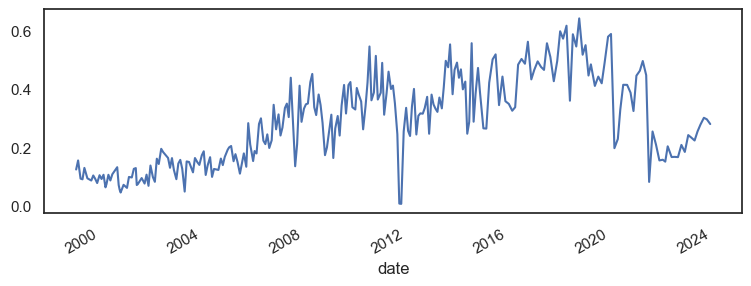

In [61]:
L1_similarity = pd.Series(np.diag(similarity_matrix, k=-1), index=df.index[1:], name='Similarity')
L1_similarity.plot()

In [62]:
L1_similarity = L1_similarity.astype("float")

# 4.2 Measure of pessimism/Sentiment analysis <a id="section_4_2"></a>

For the sentiment analysis, we download the Loughran-McDonald Master Dictionary from https://sraf.nd.edu/loughranmcdonald-master-dictionary/ and we upload it as a Data Frame.


To measure the sentiment, we classify all the relevant words in every communication as possitiveor negative using the Loughran-McDonald Master Dictionary, thenwe obtain a sentiment measure for each communication using the formula:

$$Pessimism_{i} = \frac{NegativeWords_{i} - PositiveWords_{i}}{TotalWords_{i}} $$

In [63]:
word_dict = pd.read_csv('https://raw.githubusercontent.com/andrewpwalters/ecb/main/Loughran-McDonald_MasterDictionary_1993-2021.csv')

In [64]:
POS_WORDS = word_dict.set_index('Word')['Positive'].loc[lambda x: x != 0].index
NEG_WORDS = word_dict.set_index('Word')['Negative'].loc[lambda x: x != 0].index

In [65]:
df['Pessimism'] = classify_sentences(df.intro_text.tolist(), POS_WORDS, NEG_WORDS, stemmer=None, average_method='all')
df['Pessimism'] *= -1

<Axes: xlabel='date', ylabel='Pessimism'>

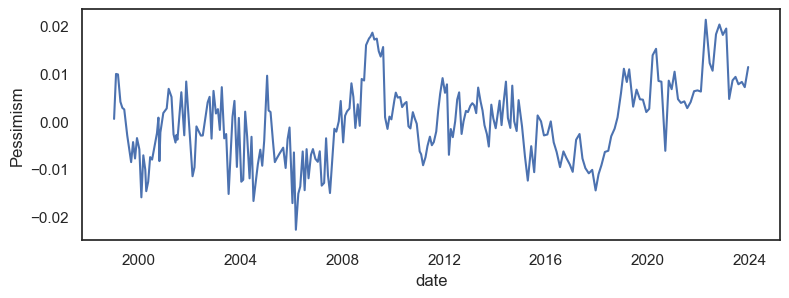

In [66]:
sns.lineplot(data=df['Pessimism'])

# 5.Data merging <a id="chapter5"></a>

## 5.1 Merging <a id="section_5_1"></a>

In [67]:
df2 = df.merge(mro, how="left",left_index= True, right_on = "meeting_date")
df2.set_index("meeting_date", inplace = True)

In [68]:
df3 = df2.merge(stock_index, how = "left", left_index= True, right_index = True )

To merge with the GDP data set I extract the quarters

In [69]:
GDP.reset_index(inplace = True)
GDP_quarter = pd.DataFrame(GDP["date"].dt.to_period('Q'))

GDP_quarter.rename(columns ={"date" : "quarter"}, inplace=True)

GDP = GDP.merge(GDP_quarter, how="left",right_index=True, left_index=True)

In [70]:
df3.reset_index(inplace= True)

df3["quarter"] = pd.Series(df3["meeting_date"]).dt.to_period('Q')

In [71]:
df4 = df3.merge(GDP, how = "left", left_on= "quarter",  right_on="quarter")
df4.reset_index(inplace= True)

The HICP is a monthly variable. For merging purposes, we extract the month and year from the meeting_date column of df4

In [72]:
df4["M-Y"] = df4["meeting_date"].apply(lambda x: x.strftime('%B-%Y'))

In [73]:
df5 = df4.merge(HICP, how= "left", left_on= "M-Y", right_on= "M-Y" )
df5.set_index("meeting_date", inplace= True)

df5.drop(['index', 'Unnamed: 0', 'level_0', 'date_x', 'date_y'], axis=1, inplace = True)

In [74]:
df6 = df5.dropna(subset=['output_gap_quart'])
df6

Name  \
meeting_date                                                      
1999-01-07    Willem F. Duisenberg: Introductory statement w...   
1999-02-04    Willem F. Duisenberg: Introductory statement w...   
1999-03-04    Willem F. Duisenberg: Introductory statement w...   
1999-04-08    Willem F. Duisenberg: Introductory statement w...   
1999-05-06    Willem F. Duisenberg: Introductory statement w...   
...                                                         ...   
2023-06-15    Christine Lagarde, Luis de Guindos: Monetary p...   
2023-07-27    Christine Lagarde, Luis de Guindos: Monetary p...   
2023-09-14    Christine Lagarde, Luis de Guindos: Monetary p...   
2023-10-26    Christine Lagarde, Luis de Guindos: Monetary p...   
2023-12-14    Christine Lagarde, Luis de Guindos: Monetary p...   

                                                           Link  \
meeting_date                                                      
1999-01-07    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-02-04    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-03-04    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-04-08    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-05-06    https://www.ecb.europa.eu/press/pressconf/1999...   
...                                                         ...   
2023-06-15    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-07-27    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-09-14    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-10-26    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-12-14    https://www.ecb.europa.eu/press/pressconf/2023...   

                       location             president   vice_president  \
meeting_date                                                             
1999-01-07                  NaN  Willem F. Duisenberg              NaN   
1999-02-04                  NaN  Willem F. Duisenberg              NaN   
1999-03-04                  NaN  Willem F. Duisenberg              NaN   
1999-04-08                  NaN  Willem F. Duisenberg              NaN   
1999-05-06                  NaN  Willem F. Duisenberg              NaN   
...                         ...                   ...              ...   
2023-06-15    Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-07-27    Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-09-14    Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-10-26               Athens     Christine Lagarde  Luis de Guindos   
2023-12-14    Frankfurt am Main     Christine Lagarde  Luis de Guindos   

                                                           text  \
meeting_date                                                      
1999-01-07     Ladies and gentlemen, the Vice-President and ...   
1999-02-04     Ladies and gentlemen, the Vice-President and ...   
1999-03-04    Ladies and gentlemen, the Vice-President and I...   
1999-04-08     Ladies and gentlemen, the Vice-President and ...   
1999-05-06     Ladies and gentlemen, the Vice-President and ...   
...                                                         ...   
2023-06-15     Good afternoon, the Vice-President and I welc...   
2023-07-27         Good afternoon, the Vice-President and I ...   
2023-09-14         Good afternoon, the Vice-President and I ...   
2023-10-26         Good afternoon, the Vice-President and I ...   
2023-12-14         Good afternoon, the Vice-President and I ...   

                                                     intro_text  Pessimism  \
meeting_date                                                                 
1999-01-07     Ladies and gentlemen, the Vice-President and ...   0.000518   
1999-02-04     Ladies and gentlemen, the Vice-President and ...   0.009967   
1999-03-04    Ladies and gentlemen, the Vice-President and I...   0.009861   
1999-04-08     Ladies and gentlemen, the Vice-President and ...   0.004115   
1999-05-06  

In [75]:
df7 = df6.merge(L1_similarity, how= "left", left_index=True, right_index=True)

df7.dropna(subset=["Similarity"], inplace = True)
df7

Name  \
meeting_date                                                      
1999-02-04    Willem F. Duisenberg: Introductory statement w...   
1999-03-04    Willem F. Duisenberg: Introductory statement w...   
1999-04-08    Willem F. Duisenberg: Introductory statement w...   
1999-05-06    Willem F. Duisenberg: Introductory statement w...   
1999-06-02    Willem F. Duisenberg: Introductory statement w...   
...                                                         ...   
2023-06-15    Christine Lagarde, Luis de Guindos: Monetary p...   
2023-07-27    Christine Lagarde, Luis de Guindos: Monetary p...   
2023-09-14    Christine Lagarde, Luis de Guindos: Monetary p...   
2023-10-26    Christine Lagarde, Luis de Guindos: Monetary p...   
2023-12-14    Christine Lagarde, Luis de Guindos: Monetary p...   

                                                           Link  \
meeting_date                                                      
1999-02-04    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-03-04    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-04-08    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-05-06    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-06-02    https://www.ecb.europa.eu/press/pressconf/1999...   
...                                                         ...   
2023-06-15    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-07-27    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-09-14    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-10-26    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-12-14    https://www.ecb.europa.eu/press/pressconf/2023...   

                       location             president   vice_president  \
meeting_date                                                             
1999-02-04                  NaN  Willem F. Duisenberg              NaN   
1999-03-04                  NaN  Willem F. Duisenberg              NaN   
1999-04-08                  NaN  Willem F. Duisenberg              NaN   
1999-05-06                  NaN  Willem F. Duisenberg              NaN   
1999-06-02                  NaN  Willem F. Duisenberg              NaN   
...                         ...                   ...              ...   
2023-06-15    Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-07-27    Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-09-14    Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-10-26               Athens     Christine Lagarde  Luis de Guindos   
2023-12-14    Frankfurt am Main     Christine Lagarde  Luis de Guindos   

                                                           text  \
meeting_date                                                      
1999-02-04     Ladies and gentlemen, the Vice-President and ...   
1999-03-04    Ladies and gentlemen, the Vice-President and I...   
1999-04-08     Ladies and gentlemen, the Vice-President and ...   
1999-05-06     Ladies and gentlemen, the Vice-President and ...   
1999-06-02     Ladies and gentlemen, the Vice-President and ...   
...                                                         ...   
2023-06-15     Good afternoon, the Vice-President and I welc...   
2023-07-27         Good afternoon, the Vice-President and I ...   
2023-09-14         Good afternoon, the Vice-President and I ...   
2023-10-26         Good afternoon, the Vice-President and I ...   
2023-12-14         Good afternoon, the Vice-President and I ...   

                                                     intro_text  Pessimism  \
meeting_date                                                                 
1999-02-04     Ladies and gentlemen, the Vice-President and ...   0.009967   
1999-03-04    Ladies and gentlemen, the Vice-President and I...   0.009861   
1999-04-08     Ladies and gentlemen, the Vice-President and ...   0.004115   
1999-05-06     Ladies and gentlemen, the Vice-President and ...   0.002838   
1999-06-02  

## 5.2.Creating Time and Time count variables <a id="section_5_2"></a>


Now we create the Time variable which counts the number of days passed since the first announcement, and add the time(count variable)

In [76]:
df7 = df7.reset_index().reset_index().rename(columns = {"index": "Time count"})

df7["Time"] = df7["meeting_date"] - pd.to_datetime("1999-02-04")
df7["Time"] = (df7["Time"].dt.total_seconds()/86400)


df7.set_index("meeting_date", inplace = True)

In [77]:
df7

Time count                                               Name  \
meeting_date                                                                  
1999-02-04             0  Willem F. Duisenberg: Introductory statement w...   
1999-03-04             1  Willem F. Duisenberg: Introductory statement w...   
1999-04-08             2  Willem F. Duisenberg: Introductory statement w...   
1999-05-06             3  Willem F. Duisenberg: Introductory statement w...   
1999-06-02             4  Willem F. Duisenberg: Introductory statement w...   
...                  ...                                                ...   
2023-06-15           252  Christine Lagarde, Luis de Guindos: Monetary p...   
2023-07-27           253  Christine Lagarde, Luis de Guindos: Monetary p...   
2023-09-14           254  Christine Lagarde, Luis de Guindos: Monetary p...   
2023-10-26           255  Christine Lagarde, Luis de Guindos: Monetary p...   
2023-12-14           256  Christine Lagarde, Luis de Guindos: Monetary p...   

                                                           Link  \
meeting_date                                                      
1999-02-04    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-03-04    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-04-08    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-05-06    https://www.ecb.europa.eu/press/pressconf/1999...   
1999-06-02    https://www.ecb.europa.eu/press/pressconf/1999...   
...                                                         ...   
2023-06-15    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-07-27    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-09-14    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-10-26    https://www.ecb.europa.eu/press/pressconf/2023...   
2023-12-14    https://www.ecb.europa.eu/press/pressconf/2023...   

                       location             president   vice_president  \
meeting_date                                                             
1999-02-04                  NaN  Willem F. Duisenberg              NaN   
1999-03-04                  NaN  Willem F. Duisenberg              NaN   
1999-04-08                  NaN  Willem F. Duisenberg              NaN   
1999-05-06                  NaN  Willem F. Duisenberg              NaN   
1999-06-02                  NaN  Willem F. Duisenberg              NaN   
...                         ...                   ...              ...   
2023-06-15    Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-07-27    Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-09-14    Frankfurt am Main     Christine Lagarde  Luis de Guindos   
2023-10-26               Athens     Christine Lagarde  Luis de Guindos   
2023-12-14    Frankfurt am Main     Christine Lagarde  Luis de Guindos   

                                                           text  \
meeting_date                                                      
1999-02-04     Ladies and gentlemen, the Vice-President and ...   
1999-03-04    Ladies and gentlemen, the Vice-President and I...   
1999-04-08     Ladies and gentlemen, the Vice-President and ...   
1999-05-06     Ladies and gentlemen, the Vice-President and ...   
1999-06-02     Ladies and gentlemen, the Vice-President and ...   
...                                                         ...   
2023-06-15     Good afternoon, the Vice-President and I welc...   
2023-07-27         Good afternoon, the Vice-President and I ...   
2023-09-14         Good afternoon, the Vice-President and I ...   
2023-10-26         Good afternoon, the Vice-President and I ...   
2023-12-14         Good afternoon, the Vice-President and I ...   

                                                     intro_text  Pessimism  \
meeting_date                                                                 
1999-02-04     Ladies and gentlemen, the Vice-President and ...   0.009967   
1999-03-04    Ladies and gentlemen, the Vice-

## 5.3. Appliying the log transformation to similarity <a id="section_5_3"></a>

For the regression models we apply the log transformation to similarity

In [78]:
df7["log_Similarity"] = np.log(df7["Similarity"])

Now, we create the interaction of pessimisism and similarity

In [79]:
df7["Pessimism x similarity"] = df7["Pessimism"] * df7["Similarity"]

In [80]:
df7["Pessimism x log_similarity"] = df7["Pessimism"] * df7["log_Similarity"]

Finally, we drop the last observation due to the NaN values

In [81]:
df7 = df7.head(256)

# 6. Replication of Table 2: Descriptive statistics <a id="chapter6"></a>

In [82]:
Table2 = df7[["cum_ab_returns", 'AV_cum_ab_returns', 'Pessimism',  "Similarity",
     'output_gap_quart', 'Inflation', 'Delta MRO']].describe().transpose()

Table2.to_csv("Table2.csv")

Table2

count      mean       std       min       25%       50%  \
cum_ab_returns     256.0  0.000177  0.045911 -0.338674 -0.021272  0.002994   
AV_cum_ab_returns  256.0  0.031685  0.033166  0.000102  0.012648  0.024065   
Pessimism          256.0 -0.000172  0.008032 -0.022757 -0.006002 -0.000248   
Similarity         256.0  0.284253  0.148280  0.006322  0.154538  0.281361   
output_gap_quart   256.0  0.000271  0.018396 -0.135591 -0.009249 -0.000099   
Inflation          256.0  0.020801  0.016661 -0.006199  0.012397  0.020023   
Delta MRO          256.0  0.004883  0.164393 -0.750000  0.000000  0.000000   

                        75%       max  
cum_ab_returns     0.026169  0.124329  
AV_cum_ab_returns  0.041584  0.338674  
Pessimism          0.004677  0.021341  
Similarity         0.400840  0.641536  
output_gap_quart   0.011056  0.032630  
Inflation          0.024639  0.106206  
Delta MRO          0.000000  0.750000

# 7. Estimations <a id="chapter7"></a>

## 7.1 Table 3 <a id="section_7_1"></a>

### Table 3 equation 1

In [83]:
x = df7[['output_gap_quart', "Inflation", "Delta MRO"]]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "1"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg1.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     8.119
Date:                Sat, 24 Feb 2024   Prob (F-statistic):           3.50e-05
Time:                        13:10:16   Log-Likelihood:                -253.68
No. Observations:                 256   AIC:                             515.4
Df Residuals:                     252   BIC:                             529.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1466      0.073  

### Table 3 equation 2

In [84]:
x = df7[['Time']]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq2 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "2"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     137.8
Date:                Sat, 24 Feb 2024   Prob (F-statistic):           1.05e-25
Time:                        13:10:16   Log-Likelihood:                -210.02
No. Observations:                 256   AIC:                             424.0
Df Residuals:                     254   BIC:                             431.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1095      0.067    -31.627      0.0

### Table 3 equation 3

In [85]:
x = df7[["Time",'output_gap_quart', "Inflation", "Delta MRO"]]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq3 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "3"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg3.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     61.15
Date:                Sat, 24 Feb 2024   Prob (F-statistic):           5.21e-36
Time:                        13:10:17   Log-Likelihood:                -178.40
No. Observations:                 256   AIC:                             366.8
Df Residuals:                     251   BIC:                             384.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.8147      0.072  

### Table 3 equation 4

In [86]:
x = df7[["Time count",'output_gap_quart', "Inflation", "Delta MRO"]]
y = df7["log_Similarity"]

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq4 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "4"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg4.csv', 'w') as f:
    f.write(csv_data)


                            OLS Regression Results                            
Dep. Variable:         log_Similarity   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     65.11
Date:                Sat, 24 Feb 2024   Prob (F-statistic):           1.04e-37
Time:                        13:10:18   Log-Likelihood:                -174.38
No. Observations:                 256   AIC:                             358.8
Df Residuals:                     251   BIC:                             376.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.8776      0.073  

### Table 3

We merge the results of each equation to obtain the Table 3:

In [87]:
merge1 = eq1.merge(eq2, how ="outer", left_index=True, right_index= True)
merge2 = merge1.merge(eq3, how ="outer", left_index=True, right_index= True)
merge3 = merge2.merge(eq4, how ="outer", left_index=True, right_index= True).sort_index(ascending = True)

Table3 = merge3
Table3.to_csv("2Table3.csv")
Table3

1         2          3          4
Delta MRO          0.709820       NaN   0.261886   0.272154
Inflation        -14.280953       NaN -17.761299 -16.660871
R2                 0.088133  0.351689   0.493561   0.509219
Time                    NaN  0.000160   0.000178        NaN
Time count              NaN       NaN        NaN   0.006132
const             -1.146637 -2.109483  -1.814667  -1.877570
output_gap_quart   3.327109       NaN   6.400605   6.176874

## 7.2 Table 4 <a id="section_7_2"></a>

### Table 4 equation 1

In [88]:
x = df7[["Pessimism"]]
y = df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq1 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "1"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2_1.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     7.430
Date:                Sat, 24 Feb 2024   Prob (F-statistic):            0.00686
Time:                        13:10:21   Log-Likelihood:                 512.94
No. Observations:                 256   AIC:                            -1022.
Df Residuals:                     254   BIC:                            -1015.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0318      0.002     15.532      0.0

### Table 4 equation 2

In [89]:
x = df7[["output_gap_quart", "Inflation", "Delta MRO"]]
df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq2 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "2"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2_2.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.505
Date:                Sat, 24 Feb 2024   Prob (F-statistic):             0.0597
Time:                        13:10:22   Log-Likelihood:                 513.01
No. Observations:                 256   AIC:                            -1018.
Df Residuals:                     252   BIC:                            -1004.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0283      0.004  

### Table 4 equation 3

In [90]:
x = df7[["Pessimism x log_similarity"]]
df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq3 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "3"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2_3.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     6.301
Date:                Sat, 24 Feb 2024   Prob (F-statistic):             0.0127
Time:                        13:10:23   Log-Likelihood:                 512.39
No. Observations:                 256   AIC:                            -1021.
Df Residuals:                     254   BIC:                            -1014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Table 4 equation 4

In [93]:
x = df7[["Pessimism x log_similarity", "output_gap_quart", "Inflation", "Delta MRO"]]
df7['AV_cum_ab_returns']

x = sm.add_constant(x)


result = sm.OLS(y, x).fit()

eq4 = pd.concat([pd.DataFrame(result.params),  pd.Series(result.rsquared, index = ["R2"])], axis = 0).rename(columns= {0: "4"})

print(result.summary())

csv_data =result.summary().as_csv()

with open('2reg2_4.csv', 'w') as f:
    f.write(csv_data)

                            OLS Regression Results                            
Dep. Variable:      AV_cum_ab_returns   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.704
Date:                Sat, 24 Feb 2024   Prob (F-statistic):             0.0310
Time:                        13:24:09   Log-Likelihood:                 514.65
No. Observations:                 256   AIC:                            -1019.
Df Residuals:                     251   BIC:                            -1002.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Table 4 equation 5

Equation 5 is ommitted as the MRO surprise variable is built using Bloomberg consensus and we do not have access to it.

### Table 4

We merge the results of each equation to obtain the Table 4:

In [92]:
merge1 = eq1.merge(eq2, how ="outer", left_index=True, right_index= True)
merge2 = merge1.merge(eq3, how ="outer", left_index=True, right_index= True)
merge3 = merge2.merge(eq4, how ="outer", left_index=True, right_index= True).sort_index(ascending = True)


Table4 = merge3
Table4.to_csv("2Table4.csv")
Table4

1         2         3         4
Delta MRO                        NaN -0.032591       NaN -0.025374
Inflation                        NaN  0.170673       NaN  0.047082
Pessimism                   0.696154       NaN       NaN       NaN
Pessimism x log_similarity       NaN       NaN -0.405044 -0.326287
R2                          0.028422  0.028958  0.024208  0.041308
const                       0.031805  0.028339  0.031887  0.031019
output_gap_quart                 NaN -0.164827       NaN -0.096266